 # Ejemplo de problema de clasificación multietiqueta

In [206]:
import tensorflow as tf
print(tf.__version__)

2.18.0


### Imports necesarios

In [207]:
import os
#!pip install kagglehub
import kagglehub
#!pip install pandas
import pandas as pd
import re
import random
import numpy as np
#!pip install matplotlib
import matplotlib.pyplot as plt
#!pip install seaborn
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
#!pip install scikit-learn
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, hamming_loss, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight

### Importamos el dataset desde kaggle

In [208]:
# Download latest version
path = kagglehub.dataset_download("ashpalsingh1525/imdb-movies-dataset")

print("Path to dataset files:", path)

# Listar los archivos descargados
print("Archivos en el directorio:", os.listdir(path))

Path to dataset files: /home/alumnadotarde/.cache/kagglehub/datasets/ashpalsingh1525/imdb-movies-dataset/versions/1
Archivos en el directorio: ['imdb_movies.csv']


In [209]:
# Ruta completa del archivo CSV
csv_path = os.path.join(path, "imdb_movies.csv")

# Cargar el dataset
df = pd.read_csv(csv_path)

# Mostrar los nombres de las columnas
print("Columnas del dataset:", df.columns)

# Mostrar las primeras filas para ver la estructura
df.info()
display(df.head())
df["status"].value_counts()
df["crew"].value_counts().sum()
display(df["overview"])


Columnas del dataset: Index(['names', 'date_x', 'score', 'genre', 'overview', 'crew', 'orig_title',
       'status', 'orig_lang', 'budget_x', 'revenue', 'country'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10178 entries, 0 to 10177
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   names       10178 non-null  object 
 1   date_x      10178 non-null  object 
 2   score       10178 non-null  float64
 3   genre       10093 non-null  object 
 4   overview    10178 non-null  object 
 5   crew        10122 non-null  object 
 6   orig_title  10178 non-null  object 
 7   status      10178 non-null  object 
 8   orig_lang   10178 non-null  object 
 9   budget_x    10178 non-null  float64
 10  revenue     10178 non-null  float64
 11  country     10178 non-null  object 
dtypes: float64(3), object(9)
memory usage: 954.3+ KB


,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country
0,Creed III,03/02/2023,73.0,"Drama, Action","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso...",Creed III,Released,English,75000000.0,2.716167e+08,AU
1,Avatar: The Way of Water,12/15/2022,78.0,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",Avatar: The Way of Water,Released,English,460000000.0,2.316795e+09,AU
2,The Super Mario Bros. Movie,04/05/2023,76.0,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P...",The Super Mario Bros. Movie,Released,English,100000000.0,7.244590e+08,AU
3,Mummies,01/05/2023,70.0,"Animation, Comedy, Family, Adventure, Fantasy","Through a series of unfortunate events, three ...","Óscar Barberán, Thut (voice), Ana Esther Albor...",Momias,Released,"Spanish, Castilian",12300000.0,3.420000e+07,AU
4,Supercell,03/17/2023,61.0,Action,Good-hearted teenager William always lived in ...,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin...",Supercell,Released,English,77000000.0,3.409420e+08,US


0        After dominating the boxing world, Adonis Cree...
1        Set more than a decade after the events of the...
2        While working underground to fix a water main,...
3        Through a series of unfortunate events, three ...
4        Good-hearted teenager William always lived in ...
                               ...                        
10173    In 1979 Santa Barbara, California, Dorothea Fi...
10174    When DEA agents are taken captive by a ruthles...
10175    Barley Scott Blair, a Lisbon-based editor of R...
10176    Darkman and Durant return and they hate each o...
10177    Princess Odette and Prince Derek are going to ...
Name: overview, Length: 10178, dtype: object

### MultiLabelBinarizer para las columnas genre y crew

In [210]:
""""
# Procesar columna 'genre'
df["genre"] = df["genre"].fillna("Desconocido")
df["genre"] = df["genre"].apply(lambda x: str(x)[2:-2] if isinstance(x, list) else str(x))
df["genre"] = df["genre"].apply(lambda x: re.sub(r'\\xa0', ' ', x))
df["genre"] = df["genre"].apply(lambda x: re.sub(r'\\', '', x))
df["genre"] = df["genre"].apply(lambda x: re.sub(r'[\[\]\'\"]', '', x))
df["genre"] = df["genre"].apply(lambda x: re.sub(r'\s+', ' ', x))
df["genre"] = df["genre"].apply(lambda x: x.strip())

num_nulos_genre = df["genre"].isna().sum()
print(f"Cantidad de valores nulos en 'genre': {num_nulos_genre}")

df["genre"] = df["genre"].apply(lambda x: [genre.strip() for genre in x.split(',')] if isinstance(x, str) else x)

mlb_genre = MultiLabelBinarizer()
genres_encoded = mlb_genre.fit_transform(df["genre"])
genres_df = pd.DataFrame(genres_encoded, columns=mlb_genre.classes_)
df = pd.concat([df, genres_df], axis=1)

if "nan" in df.columns:
    df.drop(columns=["nan"], inplace=True)

# Procesar columna 'crew'
df["crew"] = df["crew"].fillna("Desconocido")
df["crew"] = df["crew"].apply(lambda x: str(x)[2:-2] if isinstance(x, list) else str(x))
df["crew"] = df["crew"].apply(lambda x: re.sub(r'\\xa0', ' ', x))
df["crew"] = df["crew"].apply(lambda x: re.sub(r'\\', '', x))
df["crew"] = df["crew"].apply(lambda x: re.sub(r'[\[\]\'\"]', '', x))
df["crew"] = df["crew"].apply(lambda x: re.sub(r'\s+', ' ', x))
df["crew"] = df["crew"].apply(lambda x: x.strip())

num_nulos_crew = df["crew"].isna().sum()
print(f"Cantidad de valores nulos en 'crew': {num_nulos_crew}")

df["crew"] = df["crew"].apply(lambda x: [person.strip() for person in x.split(',')] if isinstance(x, str) else x)

mlb_crew = MultiLabelBinarizer()
crew_encoded = mlb_crew.fit_transform(df["crew"])
crew_df = pd.DataFrame(crew_encoded, columns=mlb_crew.classes_)
df = pd.concat([df, crew_df], axis=1)

if "nan" in df.columns:
    df.drop(columns=["nan"], inplace=True)

display(df.head())
df.info()
"""

<>:1: SyntaxWarning: invalid escape sequence '\['
<>:1: SyntaxWarning: invalid escape sequence '\['
/tmp/ipykernel_7565/366265518.py:1: SyntaxWarning: invalid escape sequence '\['
  """"


'"\n# Procesar columna \'genre\'\ndf["genre"] = df["genre"].fillna("Desconocido")\ndf["genre"] = df["genre"].apply(lambda x: str(x)[2:-2] if isinstance(x, list) else str(x))\ndf["genre"] = df["genre"].apply(lambda x: re.sub(r\'\\xa0\', \' \', x))\ndf["genre"] = df["genre"].apply(lambda x: re.sub(r\'\\\', \'\', x))\ndf["genre"] = df["genre"].apply(lambda x: re.sub(r\'[\\[\\]\'"]\', \'\', x))\ndf["genre"] = df["genre"].apply(lambda x: re.sub(r\'\\s+\', \' \', x))\ndf["genre"] = df["genre"].apply(lambda x: x.strip())\n\nnum_nulos_genre = df["genre"].isna().sum()\nprint(f"Cantidad de valores nulos en \'genre\': {num_nulos_genre}")\n\ndf["genre"] = df["genre"].apply(lambda x: [genre.strip() for genre in x.split(\',\')] if isinstance(x, str) else x)\n\nmlb_genre = MultiLabelBinarizer()\ngenres_encoded = mlb_genre.fit_transform(df["genre"])\ngenres_df = pd.DataFrame(genres_encoded, columns=mlb_genre.classes_)\ndf = pd.concat([df, genres_df], axis=1)\n\nif "nan" in df.columns:\n    df.drop(col

### ENCODING

In [211]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import numpy as np
import re
from collections import Counter

# 1️⃣ Procesar la columna 'genre' para extraer las etiquetas multietiqueta y crear 'y'
df["genre"] = df["genre"].fillna("Desconocido")
df["genre"] = df["genre"].apply(lambda x: str(x)[2:-2] if isinstance(x, list) else str(x))
df["genre"] = df["genre"].apply(lambda x: re.sub(r'\\xa0', ' ', x))
df["genre"] = df["genre"].apply(lambda x: re.sub(r'\\', '', x))
df["genre"] = df["genre"].apply(lambda x: re.sub(r'[\[\]\'\"]', '', x))
df["genre"] = df["genre"].apply(lambda x: re.sub(r'\s+', ' ', x))
df["genre"] = df["genre"].apply(lambda x: x.strip())

# Convertir la columna 'genre' en listas de géneros
df["genre"] = df["genre"].apply(lambda x: [genre.strip() for genre in x.split(',')] if isinstance(x, str) else x)

# Aplicar MultiLabelBinarizer para los géneros
mlb_genre = MultiLabelBinarizer()
genres_encoded = mlb_genre.fit_transform(df["genre"])

# Crear un DataFrame con las columnas de géneros binarizados
genres_df = pd.DataFrame(genres_encoded, columns=mlb_genre.classes_)

# Añadir las columnas binarizadas de género al DataFrame original
df = pd.concat([df, genres_df], axis=1)

# Eliminar columna 'genre' después de binarizarla
df.drop(columns=["genre"], inplace=True)

# 2️⃣ Procesar la columna 'crew' limitando la cantidad de nombres únicos
df["crew"] = df["crew"].fillna("Desconocido")
df["crew"] = df["crew"].apply(lambda x: re.sub(r'[\[\]\'\"]', '', str(x)))
df["crew"] = df["crew"].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

df["crew"] = df["crew"].apply(lambda x: x.split(',') if isinstance(x, str) else [])

# Obtener los nombres más comunes
all_names = [name.strip() for sublist in df["crew"] for name in sublist]
most_common_names = set([name for name, count in Counter(all_names).most_common(500)])  # Ajusta el número según memoria

df["crew"] = df["crew"].apply(lambda x: [name.strip() for name in x if name.strip() in most_common_names])

mlb_crew = MultiLabelBinarizer()
crew_encoded = mlb_crew.fit_transform(df["crew"])
crew_df = pd.DataFrame(crew_encoded, columns=mlb_crew.classes_)

df = pd.concat([df, crew_df], axis=1)

# Eliminar la columna 'crew' después de binarizarla
df.drop(columns=["crew"], inplace=True)

# 3️⃣ Crear el DataFrame X (con las demás características)
# Convertir 'date_x' en un objeto datetime y extraer sus componentes (year, month, day)
df['date_x'] = pd.to_datetime(df['date_x'], errors='coerce')
df['year'] = df['date_x'].dt.year
df['month'] = df['date_x'].dt.month
df['day'] = df['date_x'].dt.day

# One-Hot Encoding para variables categóricas
categorical_cols = ["orig_lang", "country"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Crear la columna ROI (Return on Investment)
df["ROI"] = df["revenue"] / df["budget_x"]
df["ROI"].replace([np.inf, -np.inf], np.nan, inplace=True)  # Manejar divisiones por cero
df["ROI"].fillna(0, inplace=True)  # Si budget_x es 0, asignamos ROI = 0

# Eliminar columnas irrelevantes
df.drop(columns=["names", "orig_title", "status", "date_x"], inplace=True)

# 4️⃣ Incluir la columna 'overview' en X
# Vectorización de 'overview' usando TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=500)  # Ajustar el número de características según sea necesario
overview_tfidf = tfidf_vectorizer.fit_transform(df["overview"])

# Convertir la matriz de características en un DataFrame
overview_df = pd.DataFrame(overview_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Concatenar el DataFrame resultante de la columna 'overview' a X
X = pd.concat([df.drop(columns=["overview"]), overview_df], axis=1)

# 5️⃣ Crear y
y = genres_df  # y es solo los géneros binarizados

# Mostrar información de X e y
print("Tamaño de X:", X.shape)
print("Tamaño de y:", y.shape)

# Guardar X e y por separado en archivos CSV
X.to_csv("X_data.csv", index=False)
y.to_csv("y_data.csv", index=False)

# 6️⃣ Análisis de desajuste de pesos en la variable y
genre_counts = genres_df.sum(axis=0)
print("Distribución de géneros:")
print(genre_counts)
display(X)
display(y)


/tmp/ipykernel_7565/4050235149.py:68: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["ROI"].replace([np.inf, -np.inf], np.nan, inplace=True)  # Manejar divisiones por cero
/tmp/ipykernel_7565/4050235149.py:69: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 

Tamaño de X: (10178, 1139)
Tamaño de y: (10178, 20)
Distribución de géneros:
Action             2752
Adventure          1890
Animation          1468
Comedy             2943
Crime              1272
Desconocido          85
Documentary         217
Drama              3812
Family             1407
Fantasy            1382
History             422
Horror             1554
Music               277
Mystery             862
Romance            1576
Science Fiction    1261
TV Movie            212
Thriller           2605
War                 282
Western             131
dtype: int64


,score,budget_x,revenue,Action,Adventure,Animation,Comedy,Crime,Desconocido,Documentary,...,work,working,works,world,wrong,year,years,york,young,younger
0,73.0,75000000.0,2.716167e+08,1,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.184181,0.0,0.0,0.0,0.0,0.0,0.000000
1,78.0,460000000.0,2.316795e+09,1,1,0,0,0,0,0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,76.0,100000000.0,7.244590e+08,0,1,1,1,0,0,0,...,0.0,0.302985,0.0,0.180508,0.0,0.0,0.0,0.0,0.0,0.000000
3,70.0,12300000.0,3.420000e+07,0,1,1,1,0,0,0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
4,61.0,77000000.0,3.409420e+08,1,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10173,73.0,7000000.0,9.353729e+06,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.300729
10174,54.0,9145817.8,6.698361e+06,1,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
10175,61.0,21800000.0,2.299799e+07,0,0,0,0,0,0,0,...,0.0,0.404251,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
10176,55.0,116000000.0,4.756613e+08,1,1,0,0,0,0,0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


,Action,Adventure,Animation,Comedy,Crime,Desconocido,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,0,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10173,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
10174,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10175,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
10176,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0


### Entrenamiento

In [212]:
# 1️⃣ **X** y **y** ya están preparados en este punto
# X contiene las características (todas menos las de género)
# y contiene las etiquetas binarizadas de los géneros

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2️⃣ Calcular los pesos de las clases
# Obtener las clases de género de y_train (en caso de que estén en formato multietiqueta)
genre_labels = y_train.columns

# Aplanar las etiquetas y obtener las clases únicas de las etiquetas binarias
y_train_flat = y_train.values.flatten()

# Calcular los pesos de las clases basados en la frecuencia de las clases en el conjunto de entrenamiento
genre_weights = compute_class_weight('balanced', classes=np.unique(y_train_flat), y=y_train_flat)

# Crear un diccionario con los nombres de las clases y sus pesos
class_weight_dict = dict(zip(np.unique(y_train_flat), genre_weights))
print(f"Class weights: {class_weight_dict}")

# 3️⃣ Normalizar las características numéricas (X)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4️⃣ Crear el modelo de red neuronal
model = Sequential()

# Añadir las capas del modelo
model.add(Dense(1024, input_dim=X_train.shape[1], activation='relu', kernel_regularizer='l2'))  # Aumentar unidades y añadir regularización L2
model.add(BatchNormalization())  # Añadir BatchNormalization para mejorar la convergencia
model.add(Dropout(0.5))  # Regularización con Dropout

model.add(Dense(512, activation='relu', kernel_regularizer='l2'))  # Aumentar unidades y añadir L2
model.add(BatchNormalization())  # BatchNormalization
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu', kernel_regularizer='l2'))  # Añadir más unidades y regularización
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu', kernel_regularizer='l2'))  # Capa adicional para mayor capacidad
model.add(Dropout(0.5))

# Última capa con el número correcto de unidades (20 clases)
model.add(Dense(20, activation='sigmoid'))  # 20 clases para multilabel

# 5️⃣ Compilar el modelo con optimizador y tasa de aprendizaje ajustada
optimizer = Adam(learning_rate=0.0001)  # Ajuste de la tasa de aprendizaje
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 6️⃣ Entrenar el modelo con EarlyStopping y los pesos de las clases
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Añadir ReduceLROnPlateau para ajustar la tasa de aprendizaje si no mejora el val_loss
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(
    X_train_scaled, 
    y_train, 
    epochs=200, 
    batch_size=32,  # Aumentar el tamaño del batch
    validation_data=(X_test_scaled, y_test), 
    callbacks=[early_stopping, lr_reduction],
    class_weight=class_weight_dict  # Aquí pasamos el diccionario de pesos
)

# 7️⃣ Mostrar el rendimiento del modelo
print(f"Última val_loss: {history.history['val_loss'][-1]}")
print(f"Última val_accuracy: {history.history['val_accuracy'][-1]}")

# 8️⃣ Evaluar el modelo en los datos de prueba
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")


Class weights: {0: 0.5743429127692894, 1: 3.8627953316253913}
Epoch 1/200


/home/alumnadotarde/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


255/255 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.0693 - loss: 21.4959 - val_accuracy: 0.1798 - val_loss: 16.0434 - learning_rate: 1.0000e-04
Epoch 2/200
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.1031 - loss: 14.8766 - val_accuracy: 0.2156 - val_loss: 11.3255 - learning_rate: 1.0000e-04
Epoch 3/200
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.1114 - loss: 10.4580 - val_accuracy: 0.2652 - val_loss: 7.8415 - learning_rate: 1.0000e-04
Epoch 4/200
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.1287 - loss: 7.2041 - val_accuracy: 0.3001 - val_loss: 5.3204 - learning_rate: 1.0000e-04
Epoch 5/200
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.1678 - loss: 4.8699 - val_accuracy: 0.3310 - val_loss: 3.5427 - learning_rate: 1.0000e-04
Epoch 6/200
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2105 - loss: 3.2381 - val_accuracy: 0.3399 - val_loss: 2.3275 - learning_rate: 1.0000e-04
Epoch 7/200
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - acc

In [213]:
# Realizar las predicciones
y_pred_prob = model.predict(X_test_scaled)

# Convertir las probabilidades a etiquetas binarias (0 o 1)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculo de las métricas
subset_accuracy = accuracy_score(y_test, y_pred)
hamming = hamming_loss(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='samples')
recall = recall_score(y_test, y_pred, average='samples')
f1 = f1_score(y_test, y_pred, average='samples')

print(f"Subset Accuracy: {subset_accuracy:.22f}")
print(f"Hamming Loss: {hamming}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Subset Accuracy: 0.8590373280943025546819
Hamming Loss: 0.00869351669941061
Precision: 0.9838490504256712
Recall: 0.9442277107306577
F1 Score: 0.9589886265230078


/home/alumnadotarde/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


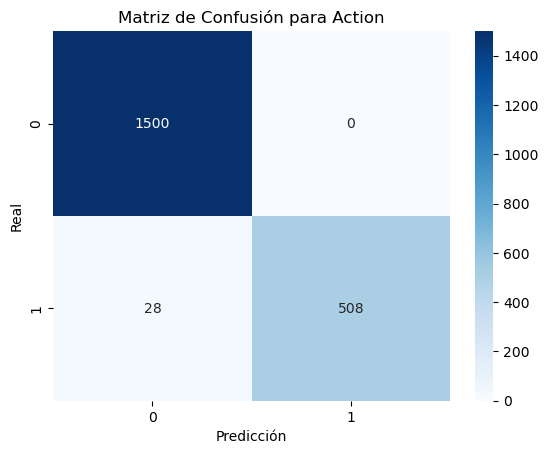

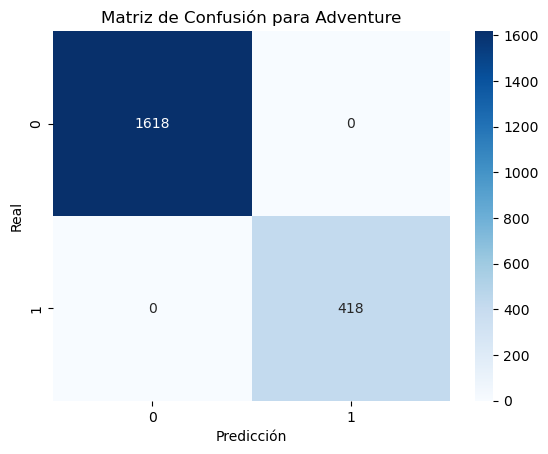

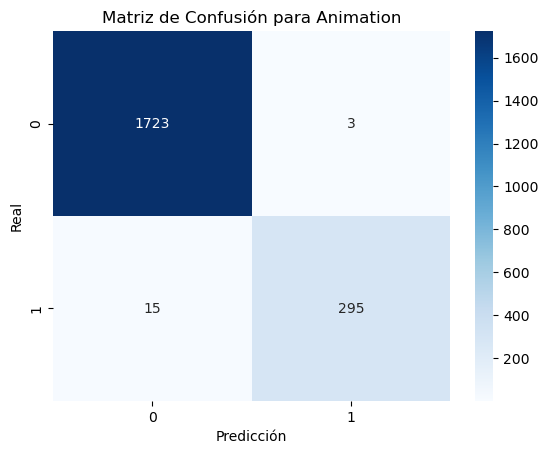

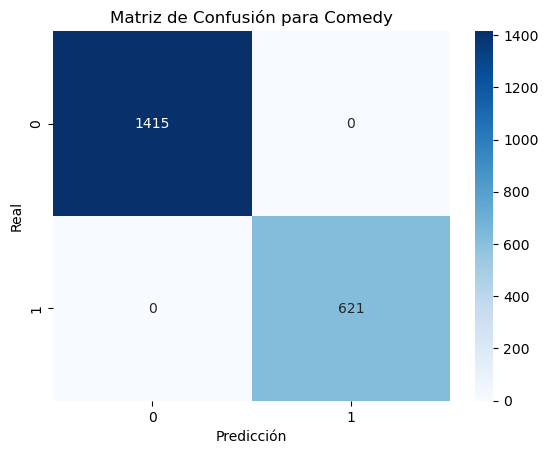

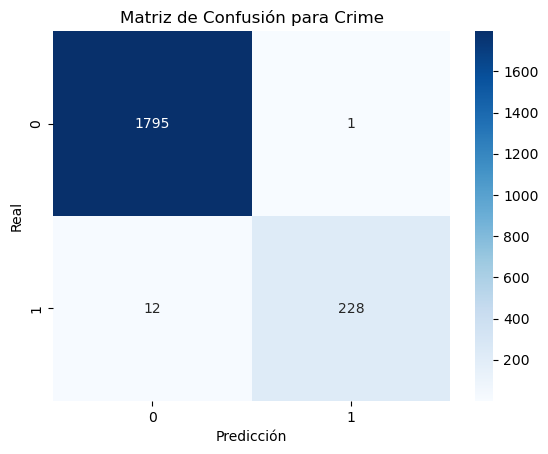

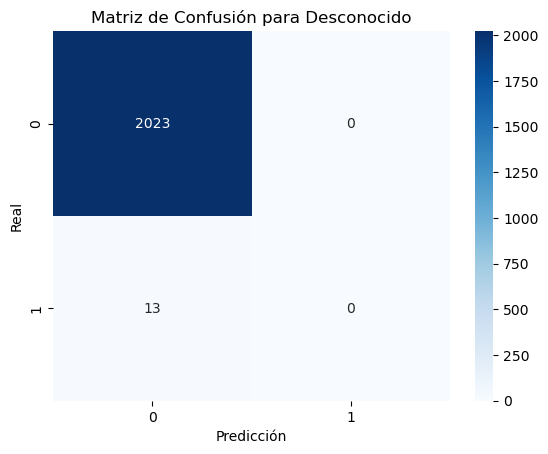

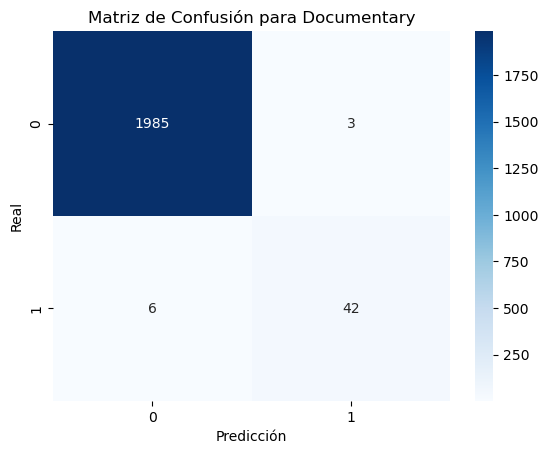

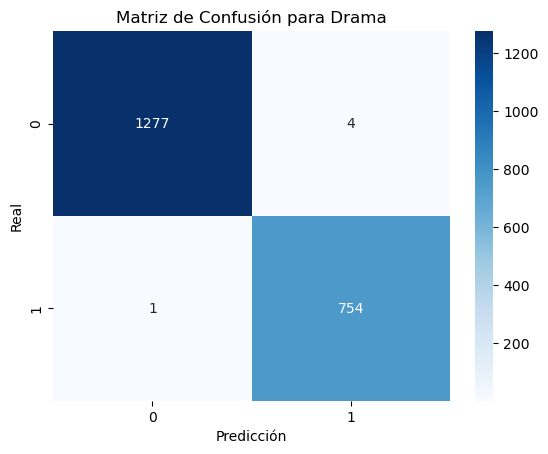

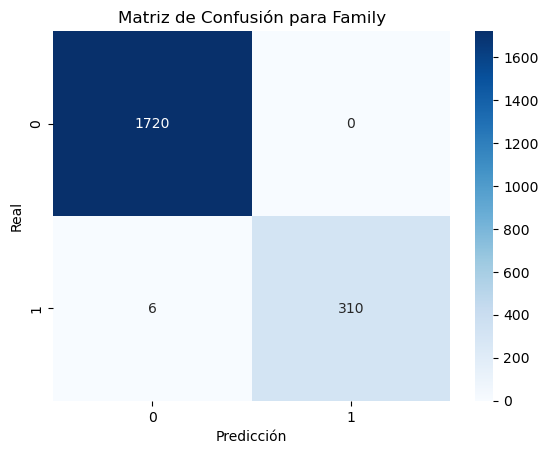

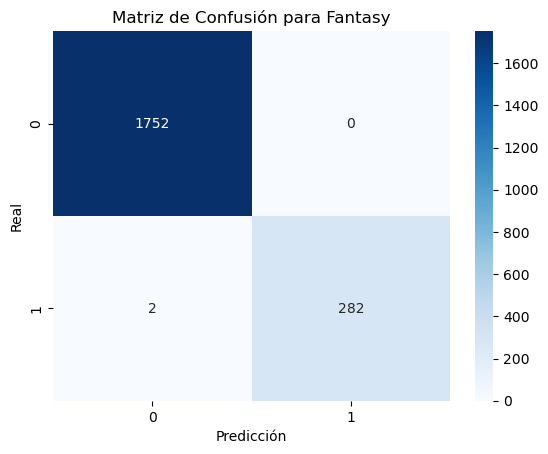

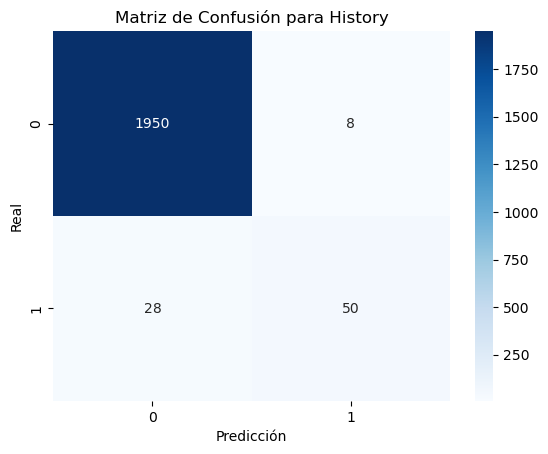

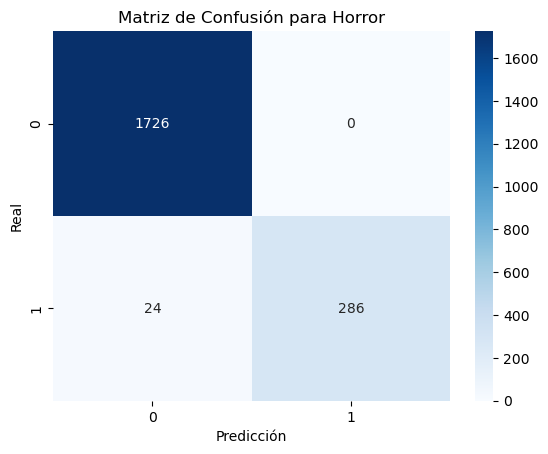

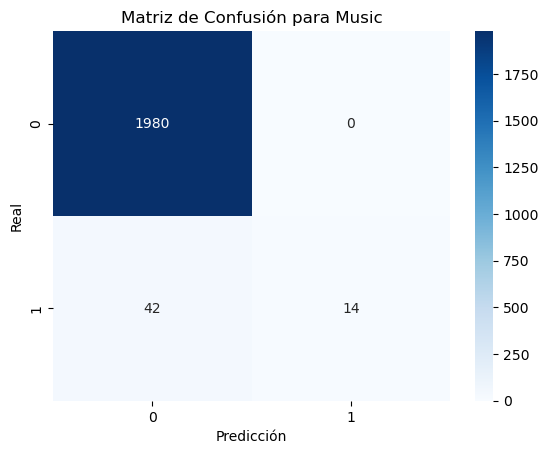

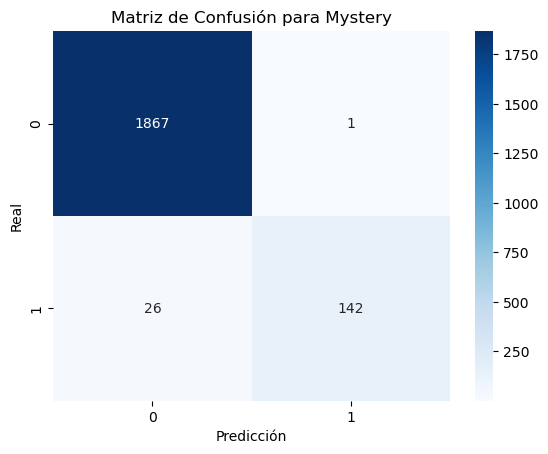

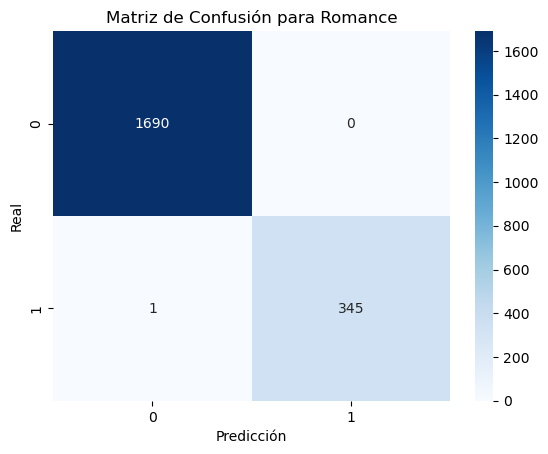

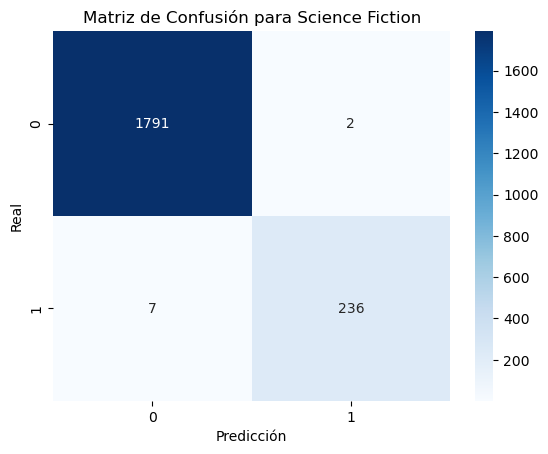

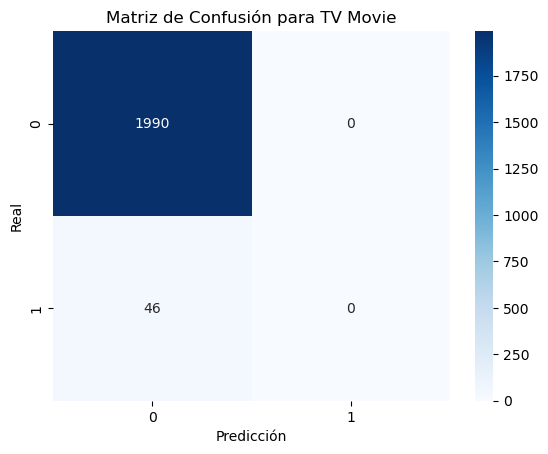

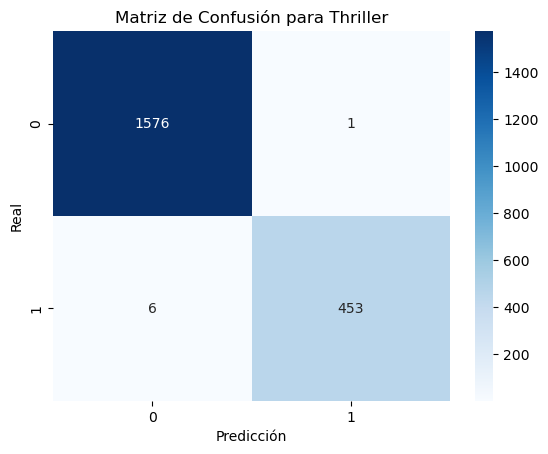

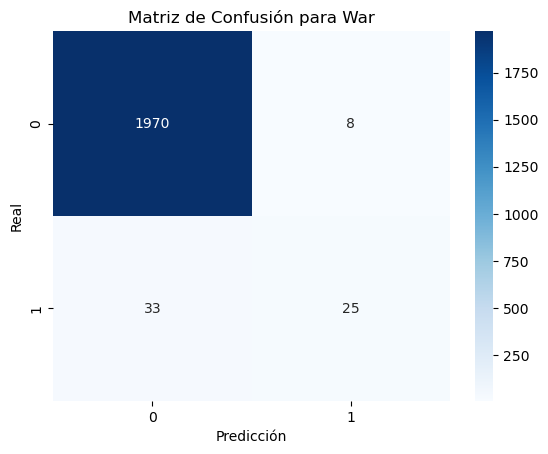

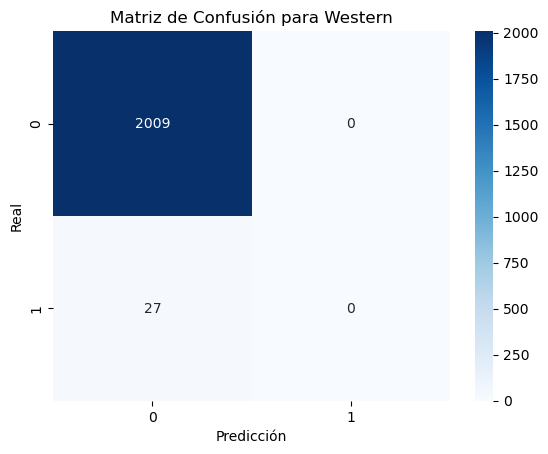

In [214]:
# Generar la matriz de confusión para cada etiqueta
for i, label in enumerate(y.columns):
    cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title(f"Matriz de Confusión para {label}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()


In [215]:
# Realizar las predicciones
y_pred_prob = model.predict(X_test_scaled)

# Convertir las probabilidades a etiquetas binarias (0 o 1)
y_pred = (y_pred_prob > 0.5).astype(int)

# Reporte de clasificación
report = classification_report(y_test, y_pred, target_names=y.columns)

# Mostrar el reporte
print(report)
      
display(y_test.iloc[0:5,:])
display(y_pred[0:5,:])

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
                 precision    recall  f1-score   support

         Action       1.00      0.95      0.97       536
      Adventure       1.00      1.00      1.00       418
      Animation       0.99      0.95      0.97       310
         Comedy       1.00      1.00      1.00       621
          Crime       1.00      0.95      0.97       240
    Desconocido       0.00      0.00      0.00        13
    Documentary       0.93      0.88      0.90        48
          Drama       0.99      1.00      1.00       755
         Family       1.00      0.98      0.99       316
        Fantasy       1.00      0.99      1.00       284
        History       0.86      0.64      0.74        78
         Horror       1.00      0.92      0.96       310
          Music       1.00      0.25      0.40        56
        Mystery       0.99      0.85      0.91       168
        Romance       1.00      1.00      1.00       346
Science Fiction       0.99      0.97      0.98  

/home/alumnadotarde/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alumnadotarde/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Action,Adventure,Animation,Comedy,Crime,Desconocido,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
8505,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3130,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
718,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
9847,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2760,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0


array([[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

In [216]:
from sklearn.metrics import multilabel_confusion_matrix


multilabel_confusion_matrix(y_test, y_pred)

array([[[1500,    0],
        [  28,  508]],

       [[1618,    0],
        [   0,  418]],

       [[1723,    3],
        [  15,  295]],

       [[1415,    0],
        [   0,  621]],

       [[1795,    1],
        [  12,  228]],

       [[2023,    0],
        [  13,    0]],

       [[1985,    3],
        [   6,   42]],

       [[1277,    4],
        [   1,  754]],

       [[1720,    0],
        [   6,  310]],

       [[1752,    0],
        [   2,  282]],

       [[1950,    8],
        [  28,   50]],

       [[1726,    0],
        [  24,  286]],

       [[1980,    0],
        [  42,   14]],

       [[1867,    1],
        [  26,  142]],

       [[1690,    0],
        [   1,  345]],

       [[1791,    2],
        [   7,  236]],

       [[1990,    0],
        [  46,    0]],

       [[1576,    1],
        [   6,  453]],

       [[1970,    8],
        [  33,   25]],

       [[2009,    0],
        [  27,    0]]])